In [1]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
from utils import ts_stats, create_sequences
from deepant import ForecastBasedDataset, DataModule, DeepAnT, ForecastBasedAD
from pytorch_lightning.callbacks import ModelCheckpoint

import pytorch_lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns

pl.seed_everything(42, workers=True)


df = pd.read_csv('../data/Non_Disturbed_Resample_m.csv', parse_dates=['Date'])
ts_stats(df)
## Interpolación
df = df.interpolate()
df.isnull().mean()

Global seed set to 42


Número de TSs: 100
Largo Promedio por TS: 268.0
Promedio de Nulos por TS: 12.23


date         0.0
ndvi         0.0
ts_id        0.0
ndvi_null    0.0
id           0.0
dtype: float64

## Creación de Secuencias

In [2]:
SEQ_LEN = 10
OUT_DIMENSION = 1
NAME = 'DeepAnT_Non_Disturbed_Resample_m'
sequences, divisor, indices, dates, targets, dates_target, target_idx = create_sequences(df, SEQ_LEN)

Se crearon 25900 secuencias y 25900 targets.


In [3]:
# Eliminación de la última secuencia. Sólo Modelos Forecast Based.
idx_null = np.argwhere(np.isnan(targets))
targets = np.delete(targets, idx_null)
sequences = np.delete(sequences, idx_null, axis=0)
target_idx = np.delete(target_idx, idx_null)

targets.shape, sequences.shape, target_idx.shape, dates.shape, indices.shape


((25800,), (25800, 10), (25800,), (25900, 10), (25900, 10))

In [4]:
dataset = ForecastBasedDataset(sequences, targets)
dataset[0], targets[0]

((tensor([[0.7896],
          [0.7987],
          [0.7719],
          [0.7773],
          [0.0075],
          [0.7178],
          [0.7299],
          [0.7420],
          [0.7239],
          [0.8039]]),
  tensor(0.7040)),
 0.7040477099517982)

In [5]:
model = DeepAnT(SEQ_LEN, OUT_DIMENSION)
anomaly_detector = ForecastBasedAD(model)
dm = DataModule(sequences, targets, forecast = True)
mc = ModelCheckpoint(
    dirpath = 'checkpoints',
    save_last = True,
    save_top_k = 1,
    verbose = True,
    monitor = 'train_loss', 
    mode = 'min'
    )

mc.CHECKPOINT_NAME_LAST = f'{NAME}-best-checkpoint'


trainer = pl.Trainer(max_epochs=30,
                    accelerator="gpu",
                    devices=1, 
                    callbacks=[mc], 
                    progress_bar_refresh_rate=30, 
                    #fast_dev_run=True,
                    #overfit_batches=1
                    )
trainer.fit(anomaly_detector, dm)

/home/alfonso/miniconda3/envs/dl/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/alfonso/miniconda3/envs/dl/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:608: UserWarning: Checkpoint directory /home/alfonso/Documents/MSDS/samsara_tesis/notebooks/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint direc

Training: 0it [00:00, ?it/s]

/home/alfonso/miniconda3/envs/dl/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/alfonso/miniconda3/envs/dl/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 0, global step 807: 'train_loss' reached 0.53712 (best 0.53712), saving model to '/home/alfonso/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=0-step=807.ckpt' as top 1
Epoch 1, global step 1614: 'train_loss' reached 0.41301 (best 0.41301), saving model 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 807it [00:00, ?it/s]

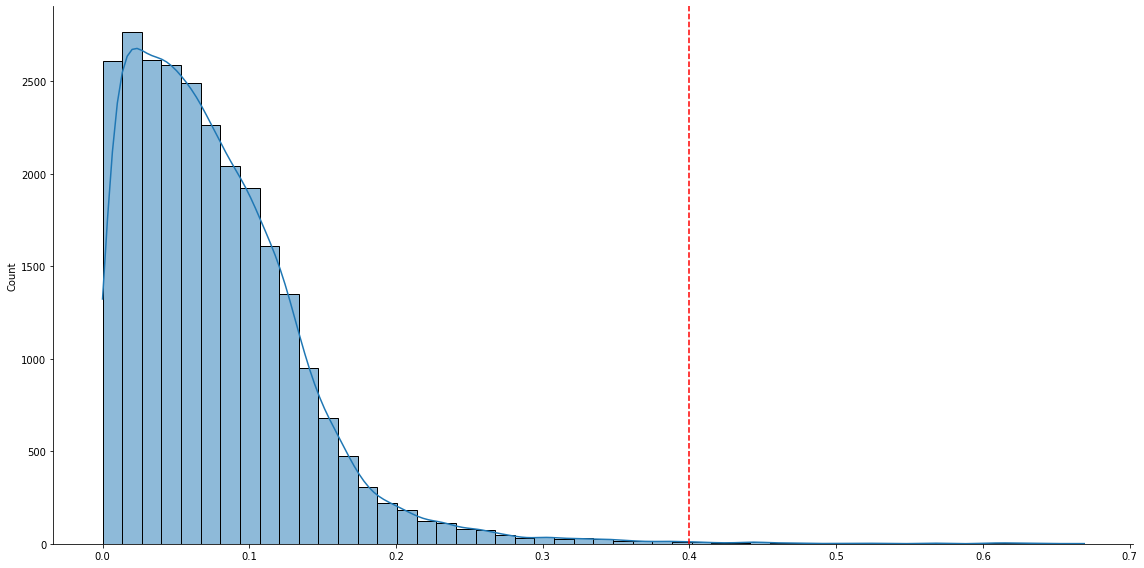

In [9]:
ADF = ForecastBasedAD.load_from_checkpoint(
                f'checkpoints/{NAME}-best-checkpoint.ckpt',
                model=model)

THRESHOLD = 0.2
def predict(trainer, model, dm, threshold):
    output = trainer.predict(model, dm)
    preds_losses = torch.tensor([item[1] for item in output]).numpy()
    sns.displot(preds_losses, bins = 50, kde = True, height = 8, aspect = 2)
    plt.axvline(x = threshold, color = 'r', linestyle = '--', label = 'Threshold Escogido')
    return preds_losses


preds = pd.Series(predict(trainer, anomaly_detector, dm, threshold=THRESHOLD), index = target_idx)
    

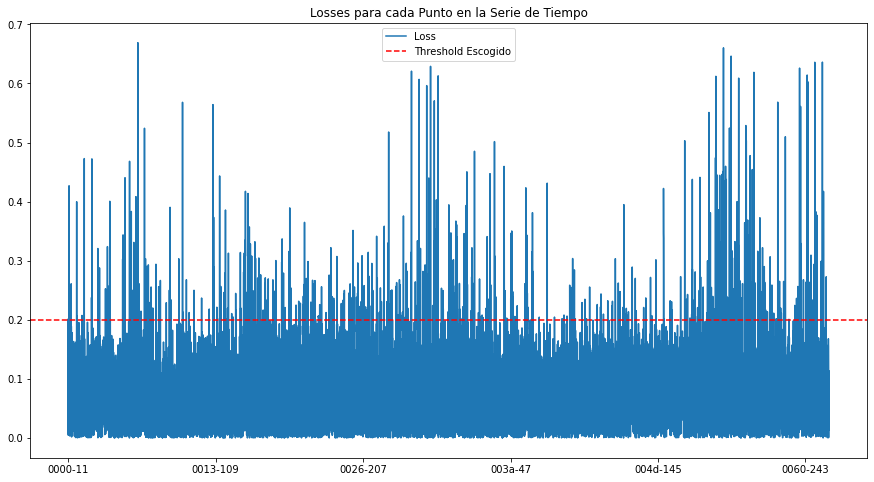

In [91]:
THRESHOLD = 0.2
def loss_plot(preds, threshold):
    preds.plot(figsize = (15,8), title = 'Losses para cada Punto en la Serie de Tiempo', label = 'Loss')
    plt.axhline(y = threshold, color = 'r', linestyle = '--', label = 'Threshold Escogido')
    plt.legend()
    plt.show();
    
def ts_plot(df, preds, threshold, alg = 'DeepAnT'):
    idx = preds.loc[lambda x: x > threshold].index
    plt.figure(figsize = (15,8))
    plt.plot(df, label = '_nolegend_')
    plt.vlines(x = idx, ymin = -100, ymax = 300,
                colors = 'teal', label = f'Anomalias Detectadas por {alg}')
    plt.title('Anomalías detectadas en la Serie de Tiempo')
    plt.legend()
    plt.show();

loss_plot(preds, THRESHOLD)

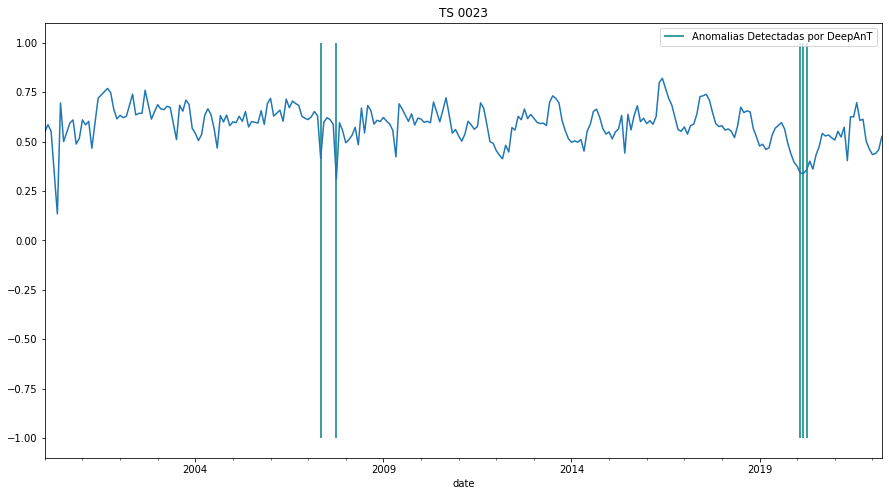

In [114]:
def show_preds(df, preds, TS_ID, THRESHOLD, figsize = (15,8)):
    anomaly_index = preds[lambda x: x > THRESHOLD].index.tolist()
    idx = df.query('ts_id == @TS_ID and id in @anomaly_index').date.tolist()
    (df.set_index('date').query('ts_id == @TS_ID').ndvi
        .plot(figsize = figsize, 
            title = f'TS {TS_ID}',
            label = '_nolegend_'))
    plt.vlines(x = idx, ymin = -1, ymax = 1,
            colors = 'teal', label = f'Anomalias Detectadas por DeepAnT');
    plt.legend();

show_preds(df, preds, '0023', THRESHOLD, figsize = (15,8))


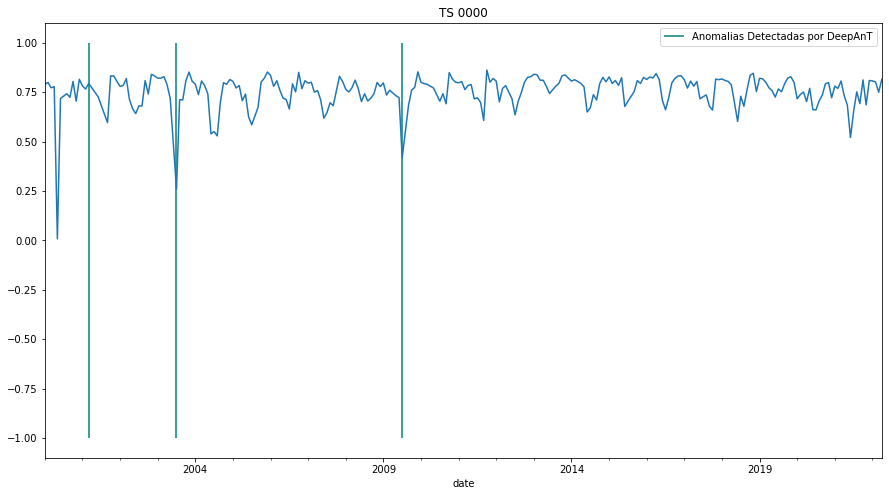

In [115]:
show_preds(df, preds, '0000', THRESHOLD, figsize = (15,8))

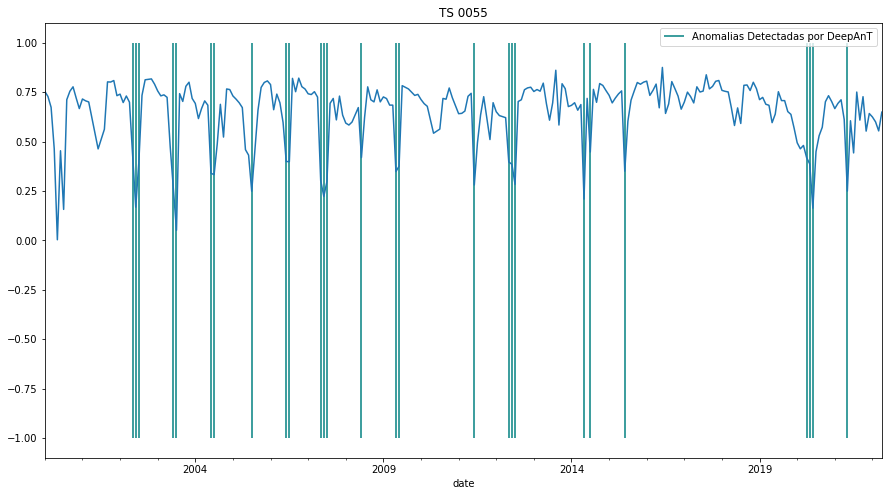

In [116]:
show_preds(df, preds, '0055', THRESHOLD, figsize = (15,8))


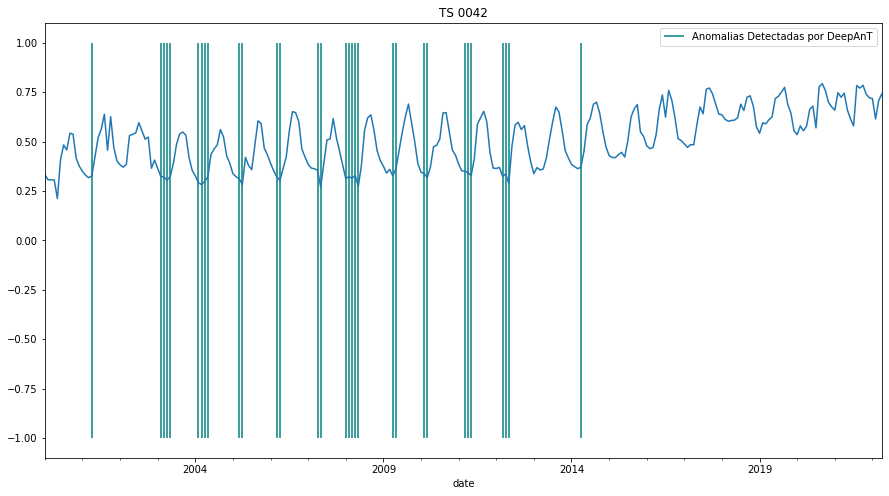

In [117]:
show_preds(df, preds, '0042', THRESHOLD, figsize = (15,8))

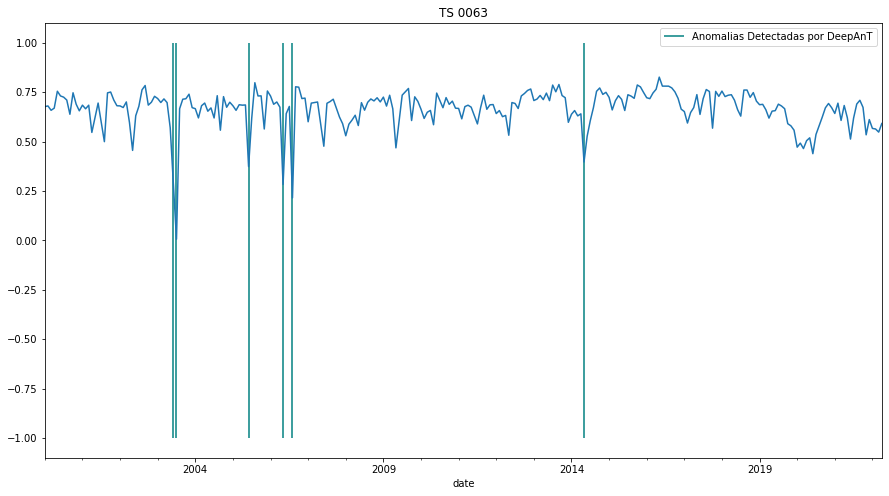

In [119]:
show_preds(df, preds, '0063', THRESHOLD, figsize = (15,8))